# **Objectif:**

**L'objectif principal de ce projet était de construire un modèle CNN capable de classer si un sujet présente ou non une tumeur à partir d'une image d'IRM. J'ai utilisé les architectures de modèles SVM, CNN et LeNet-5 ainsi que leurs poids pour entraîner le modèle sur ce problème de classification binaire. J'ai utilisé l'accuracy (taux de précision) comme métrique pour évaluer la performance du modèle, qui peut être définie comme suit :**


***Accuracy = (Nombre d’images correctement prédites / Nombre total d’images testées) × 100 %***

# **1.Importation des bibliothèques**


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from tensorflow.keras.layers import Dropout
from PIL import Image 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# **2.Importation du Data et Prétraitement**

In [2]:
data=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       label = os.path.basename(dirname)
       data.append({"filepath": os.path.join(dirname, filename), "label": label})
df = pd.DataFrame(data)
print(df)

                                              filepath label
0    /kaggle/input/brain-mri-images-for-brain-tumor...    no
1    /kaggle/input/brain-mri-images-for-brain-tumor...    no
2    /kaggle/input/brain-mri-images-for-brain-tumor...    no
3    /kaggle/input/brain-mri-images-for-brain-tumor...    no
4    /kaggle/input/brain-mri-images-for-brain-tumor...    no
..                                                 ...   ...
501  /kaggle/input/brain-mri-images-for-brain-tumor...   yes
502  /kaggle/input/brain-mri-images-for-brain-tumor...   yes
503  /kaggle/input/brain-mri-images-for-brain-tumor...   yes
504  /kaggle/input/brain-mri-images-for-brain-tumor...   yes
505  /kaggle/input/brain-mri-images-for-brain-tumor...   yes

[506 rows x 2 columns]


# **2.1. Affichage d'un extrait de la base**

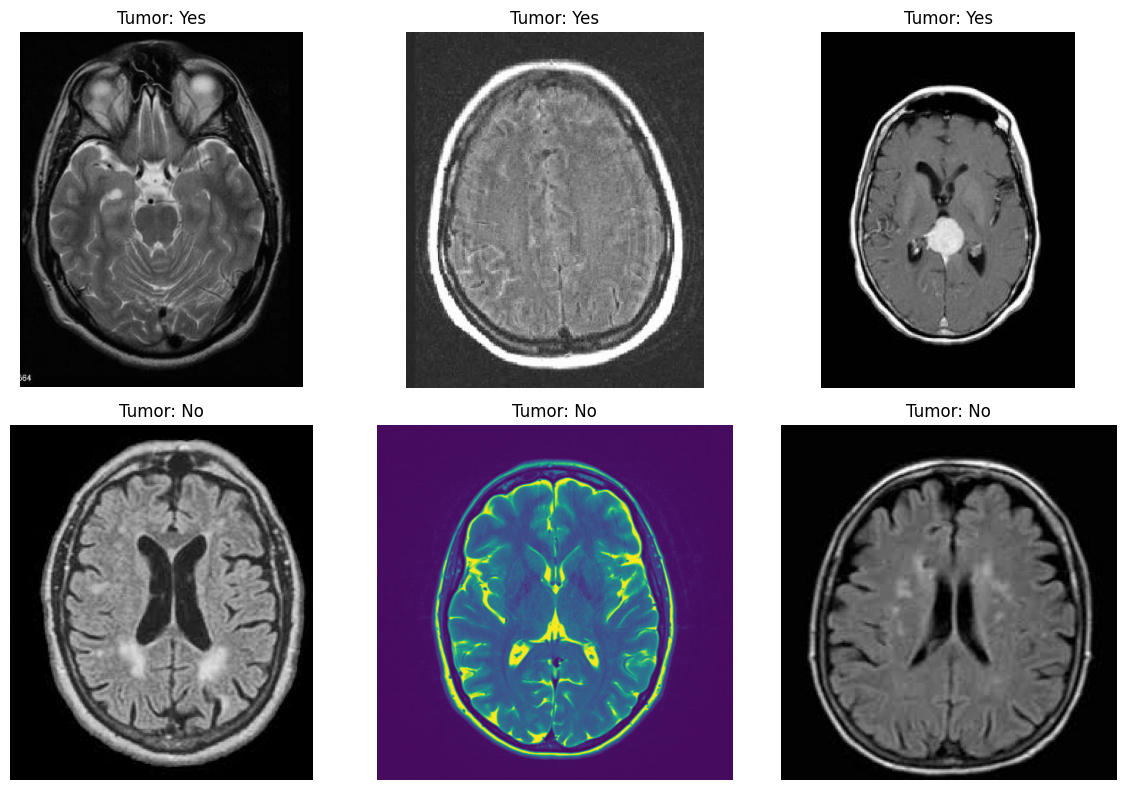

In [13]:
# Sélectionner 3 images aléatoires pour chaque classe
yes_df = df[df['label'] == 'yes'].sample(3, random_state=42)
no_df = df[df['label'] == 'no'].sample(3, random_state=42)

# Création de la figure avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Afficher les images "yes" dans la première ligne
for i, (_, row) in enumerate(yes_df.iterrows()):
    img = Image.open(row['filepath'])
    axes[0, i].imshow(img)
    axes[0, i].set_title("Tumor: Yes")
    axes[0, i].axis("off")

# Afficher les images "no" dans la deuxième ligne
for i, (_, row) in enumerate(no_df.iterrows()):
    img = Image.open(row['filepath'])
    axes[1, i].imshow(img)
    axes[1, i].set_title("Tumor: No")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# **2.2. Affichage des classes** 

Nombre de classes : 2
Nombre d'éléments par classe :
label
yes    310
no     196
Name: count, dtype: int64


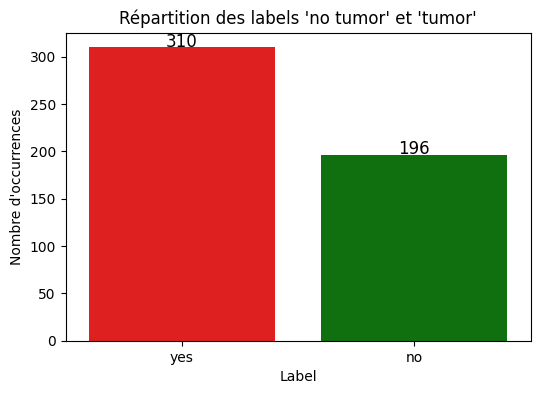

In [14]:
num_classes = df['label'].nunique()
print(f"Nombre de classes : {num_classes}")

class_counts = df['label'].value_counts()
print("Nombre d'éléments par classe :")
print(class_counts)

# Créer un bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['red', 'green'])

# Ajouter des titres et labels
plt.title("Répartition des labels 'no tumor' et 'tumor'")
plt.xlabel("Label")
plt.ylabel("Nombre d'occurrences")

# Afficher les valeurs sur les barres
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=12)

plt.show()

# **2.3. Rotation d'image**

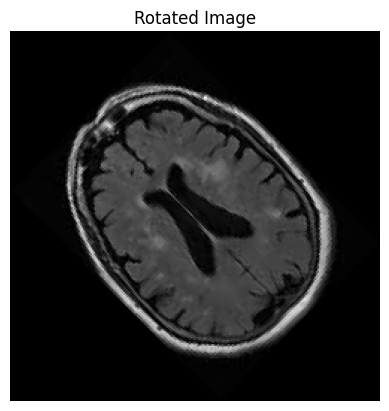

In [15]:
def rotate_image(image_path, angle=45):
    return Image.open(image_path).convert("L").rotate(angle, expand=True)
sample_image_path = df.iloc[0]['filepath']  # On prend le premier chemin d'image
# Application de la rotation de l'image
rotated_img = rotate_image(sample_image_path, angle=45)
plt.imshow(rotated_img, cmap="gray")
plt.axis("off") # Suppression des axes 
plt.title("Rotated Image")
plt.show()

# **2.4. Ajout du bruit à l'image**

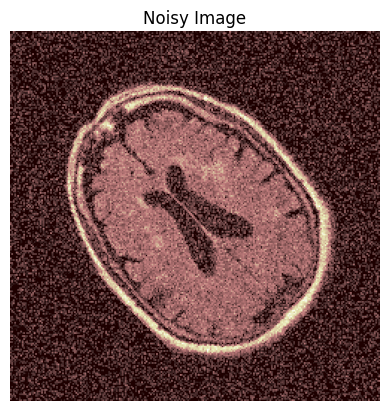

In [16]:
def add_noise(image):
# Génération d'un bruit avec une moyenne de 0 et un écart-type de 25
    noise = np.random.normal(loc=0, scale=25, size=image.shape)
 # Ajout du bruit à l'image d'origine
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)  
    return noisy_image.astype(np.uint8)
rotated_img_np = np.array(rotated_img)  # Conversion en tableau numpy
noisy_img = add_noise(rotated_img_np)
plt.imshow(noisy_img, cmap="pink")
plt.axis("off")
plt.title("Noisy Image")
plt.show()

# **3. Modèle 1: SVM**

In [17]:
# Listes pour stocker les métriques
accuracies = []
precisions = []
recalls = []
f1_scores = []
best_accuracy = 0
best_model = None

In [72]:
for i in range(10):
    # Séparation des données en ensembles d'entraînement et de test
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=i, stratify=df['label'])
    #Génère des images modifiées pour augmenter la diversité des données et éviter le surapprentissage
    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary' 
    )
    #test (sans augmentation: nest pas biaiser les resultats)
    test_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        shuffle=False   # Garde le même ordre pour les étiquettes et les prédictions
    )
    
    # Extraction d'un batch(sous-ensemble des données) pour l'entraînement et le test
    X_train, y_train = next(train_generator)
    X_test, y_test = next(test_generator)
    
    # Transformation des images 3D en vecteurs 1D pour le SVM
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
        # Entraînement du modèle SVM
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)
    
    # Prédiction et calcul des métriques
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
      best_accuracy = acc
      best_model = model
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    print(f"\nMeilleure accuracy atteinte sur les 10 itérations : {best_accuracy:.4f}")

Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.

Meilleure accuracy atteinte sur les 10 itérations : 1.0000
Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.

Meilleure accuracy atteinte sur les 10 itérations : 1.0000
Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.

Meilleure accuracy atteinte sur les 10 itérations : 1.0000
Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.

Meilleure accuracy atteinte sur les 10 itérations : 1.0000
Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.

Meilleure accuracy atteinte sur les 10 itérations : 1.0000
Found 354 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belo

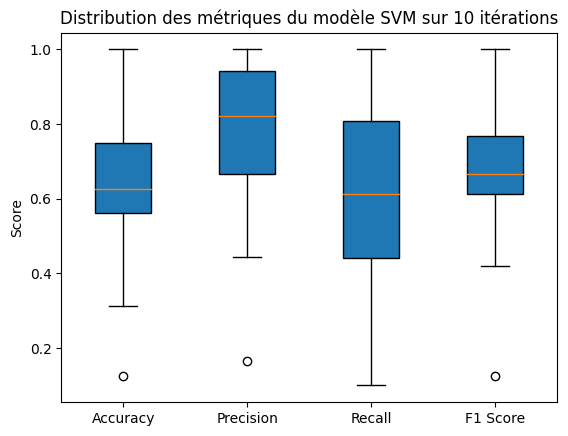

In [73]:
# Visualisation des performances avec un boxplot pour chaque métrique
metrics = [accuracies, precisions, recalls, f1_scores]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.boxplot(metrics, vert=True, patch_artist=True, labels=labels)
plt.title("Distribution des métriques du modèle SVM sur 10 itérations")
plt.ylabel("Score")
plt.show()

# **4. Modèle 2: CNN**

In [3]:
# Séparer les données en entraînement (70%), validation (15%) et test (15%)
import random
random.seed(123)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [4]:
# Génération des images avec augmentation uniquement pour l'entraînement
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_valid_test = ImageDataGenerator(rescale=1./255)

In [5]:
# Création des générateurs
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary"
)

valid_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary"
)

test_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 354 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.


In [21]:
# Définition du modèle CNN amélioré
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),   
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),   
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),   
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),   
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compilation du modèle
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [21]:
# Affichage du résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,497 (42.61 MB)

 Trainable params: 11,169,793 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback : sauvegarde le modèle avec la meilleure validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

In [24]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint]
)
# Récupérer la meilleure accuracy de validation atteinte pendant l'entraînement
best_val_acc = max(history.history['val_accuracy'])
print(f"Meilleure validation accuracy : {best_val_acc:.4f}")

# Évaluation du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy : {test_acc:.4f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6461 - loss: 1.1358
Epoch 1: val_accuracy improved from -inf to 0.61842, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6475 - loss: 1.1294 - val_accuracy: 0.6184 - val_loss: 1.1965
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6103 - loss: 0.7778
Epoch 2: val_accuracy did not improve from 0.61842
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6137 - loss: 0.7719 - val_accuracy: 0.6184 - val_loss: 3.1114
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7011 - loss: 0.6228
Epoch 3: val_accuracy did not improve from 0.61842
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7017 - loss: 0.6211 - val_accuracy: 0.6184 - val_loss: 1.7240
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7158 - loss: 0.5342
Epoch 4: val_accuracy did not improve from 0.61842
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7171 - loss: 0.5342 - val_accuracy: 0.6184

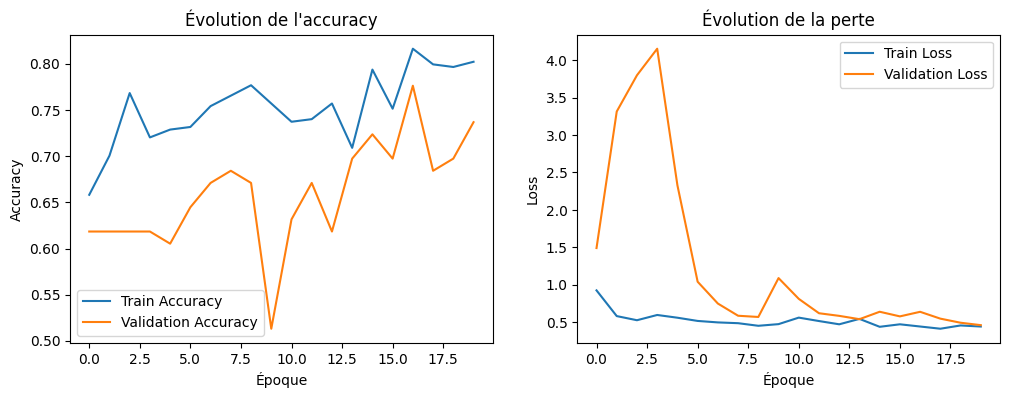

In [24]:
# Tracé des courbes d’apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de l'accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Évolution de la perte")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

plt.show()

# **5. Modèle 3: LeNet-5**

In [25]:
# Définition du modèle LeNet-5
import random
random.seed(123)
lenet_model = Sequential([
    Conv2D(6, (5,5), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(16, (5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')  # Classification binaire
])

In [26]:
# Compilation
lenet_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [27]:
# Résumé du modèle
lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │       5,393,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,406,521 (20.62 MB)

 Trainable params: 5,406,521 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Entraînement
history_lenet = lenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - accuracy: 0.5941 - loss: 0.8509 - val_accuracy: 0.7237 - val_loss: 0.5750
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.6858 - loss: 0.6015 - val_accuracy: 0.6711 - val_loss: 0.5853
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.7398 - loss: 0.5681 - val_accuracy: 0.7632 - val_loss: 0.5596
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.6489 - loss: 0.6532 - val_accuracy: 0.7237 - val_loss: 0.5548
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.7574 - loss: 0.5800 - val_accuracy: 0.7368 - val_loss: 0.5490
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.7519 - loss: 0.5313 - val_accuracy: 0.7500 - val_loss: 0.5232
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - accuracy: 0.7523 - loss: 0.5592 - val_accuracy: 0.7237 - val_loss: 0.5209
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.6886 - loss: 0.5721 - val_accu

In [29]:
# Évaluation
test_loss, test_acc = lenet_model.evaluate(test_generator)
print(f"LeNet-5 Test Accuracy: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8510 - loss: 0.3437
LeNet-5 Test Accuracy: 0.8289


# **6. Comparaison entre les 2 modèles CNN et LeNet-5**

In [30]:
# Évaluation des modèles
test_loss_cnn, test_acc_cnn = model.evaluate(test_generator)
test_loss_lenet, test_acc_lenet = lenet_model.evaluate(test_generator)

print(f"Test Accuracy - CNN amélioré : {test_acc_cnn:.4f}")
print(f"Test Accuracy - LeNet-5       : {test_acc_lenet:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.9041 - loss: 0.2680
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8510 - loss: 0.3437
Test Accuracy - CNN amélioré : 0.8816
Test Accuracy - LeNet-5       : 0.8289


In [31]:
# Afficher le tableau de comparaison
results_df = pd.DataFrame({
    "Modèle": ["CNN amélioré", "LeNet-5"],
    "Test Accuracy": [test_acc_cnn, test_acc_lenet],
    "Test Loss": [test_loss_cnn, test_loss_lenet]
})

print("\nRésultats comparatifs des modèles :\n")
print(results_df.round(4))


Résultats comparatifs des modèles :

         Modèle  Test Accuracy  Test Loss
0  CNN amélioré         0.8816     0.2687
1       LeNet-5         0.8289     0.3675


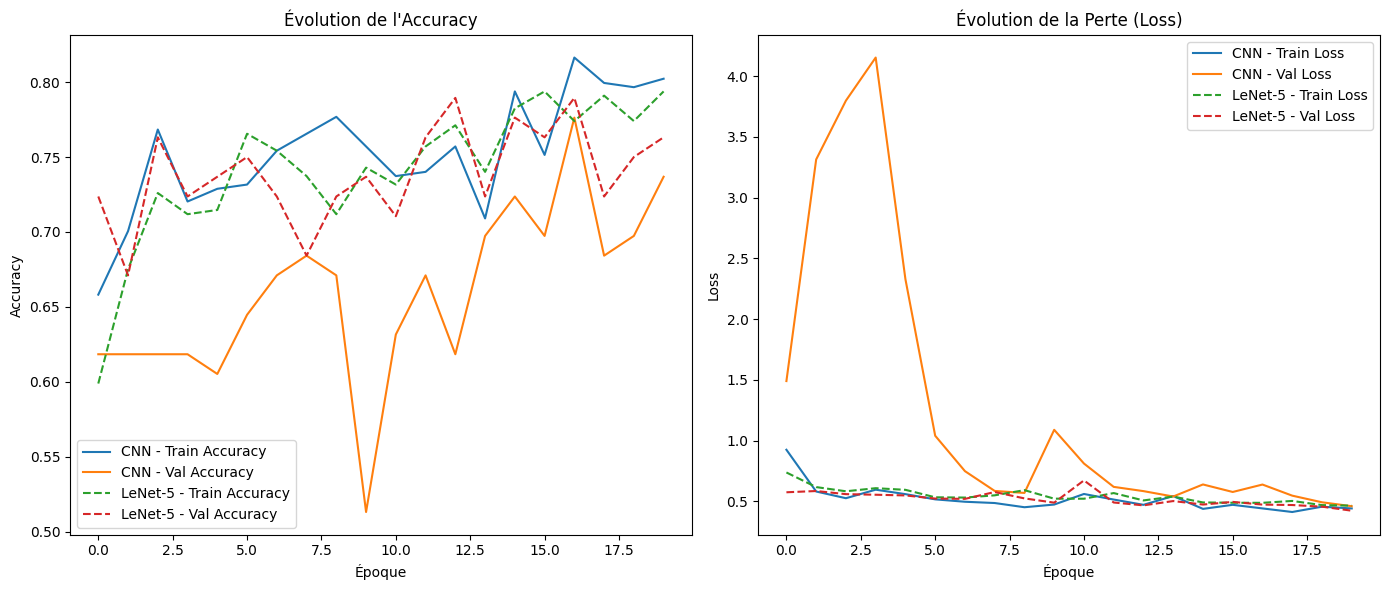

In [32]:
# Tracé des courbes d’apprentissage pour les deux modèles
plt.figure(figsize=(14, 6))

# Courbe d'Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='CNN - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN - Val Accuracy')
plt.plot(history_lenet.history['accuracy'], label='LeNet-5 - Train Accuracy', linestyle='--')
plt.plot(history_lenet.history['val_accuracy'], label='LeNet-5 - Val Accuracy', linestyle='--')
plt.title("Évolution de l'Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='CNN - Train Loss')
plt.plot(history.history['val_loss'], label='CNN - Val Loss')
plt.plot(history_lenet.history['loss'], label='LeNet-5 - Train Loss', linestyle='--')
plt.plot(history_lenet.history['val_loss'], label='LeNet-5 - Val Loss', linestyle='--')
plt.title("Évolution de la Perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# **6.2. Matrice de confusion pour les deux modèles**

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true = test_generator.classes

# Prédictions pour CNN 
y_pred_cnn = model.predict(test_generator)
y_pred_cnn_classes = (y_pred_cnn > 0.5).astype(int).flatten()

# Prédictions pour LeNet
y_pred_lenet = lenet_model.predict(test_generator)
y_pred_lenet_classes = (y_pred_lenet > 0.5).astype(int).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


# **6.2.1 Matrice de Confusion CNN amélioré**

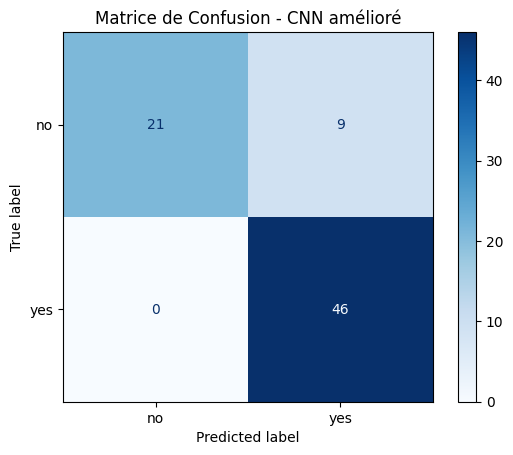

In [34]:
cm_cnn = confusion_matrix(y_true, y_pred_cnn_classes)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=test_generator.class_indices)
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - CNN amélioré")
plt.show()

In [35]:
print("Classification Report - CNN amélioré")
print(classification_report(y_true, y_pred_cnn_classes))

Classification Report - CNN amélioré
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.84      1.00      0.91        46

    accuracy                           0.88        76
   macro avg       0.92      0.85      0.87        76
weighted avg       0.90      0.88      0.88        76



# **Interprétation :**
 
***Classe 0 :***

* Précision = 1.00 : toutes les prédictions faites comme "classe 0" sont correctes.

* Rappel = 0.70 : le modèle identifie 70% des vrais cas de classe 0, mais en rate encore 30%.

* F1-score = 0.82 : bon équilibre, mais le rappel pourrait être amélioré.

  
***Classe 1 :***

* Précision = 0.84 : 84% des prédictions en classe 1 sont justes.

* Rappel = 1.00 : le modèle identifie tous les cas de classe 1.

* F1-score = 0.91 : excellente performance globale sur cette classe.

***Conclusion :*** Le CNN amélioré présente des performances excellentes sur la classe 1, avec un rappel parfait, ce qui est crucial pour ne rater aucun cas positif.
Il est également très précis sur la classe 0, mais il lui arrive de manquer des cas réels de cette classe.
Globalement, c’est un modèle très performant, particulièrement bien équilibré entre précision et rappel.

# **6.2.2 Matrice de Confusion LeNet-5**

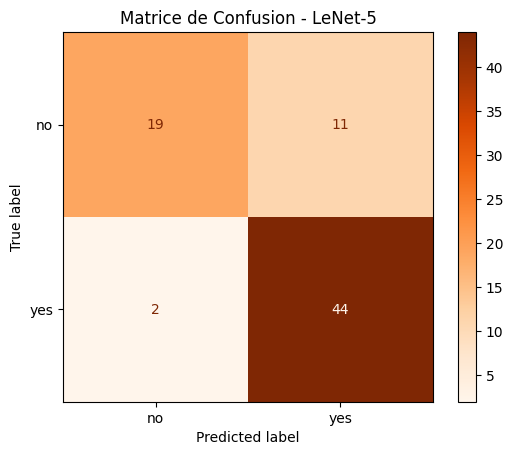

In [36]:
cm_lenet = confusion_matrix(y_true, y_pred_lenet_classes)
disp_lenet = ConfusionMatrixDisplay(confusion_matrix=cm_lenet, display_labels=test_generator.class_indices)
disp_lenet.plot(cmap=plt.cm.Oranges)
plt.title("Matrice de Confusion - LeNet-5")
plt.show()

In [37]:
print("\nClassification Report - LeNet-5")
print(classification_report(y_true, y_pred_lenet_classes))


Classification Report - LeNet-5
              precision    recall  f1-score   support

           0       0.90      0.63      0.75        30
           1       0.80      0.96      0.87        46

    accuracy                           0.83        76
   macro avg       0.85      0.79      0.81        76
weighted avg       0.84      0.83      0.82        76



# **Interprétation :**

***Classe 0 :***

* Précision = 0.90 : parmi les prédictions faites en classe 0, 90% étaient correctes.

* Rappel = 0.63 : le modèle a détecté 63% des vrais cas de classe 0.

* F1-score = 0.75 : bon compromis entre précision élevée et rappel modéré.

***Classe 1 :***

* Précision = 0.80 : 80% des prédictions en classe 1 sont correctes.

* Rappel = 0.96 : presque tous les cas réels de classe 1 ont été correctement identifiés.

* F1-score = 0.87 : très bonne performance globale sur cette classe.



***Conclusion :*** LeNet-5 montre des performances équilibrées, avec :

* Une excellente détection de la classe majoritaire (1).

* Une bonne précision sur la classe minoritaire (0), bien qu’avec un rappel plus faible.

# **6.2.3 Tableau comparatif entre les résultats**

In [74]:
# Création du tableau comparatif 
comparaison = pd.DataFrame({
    'Métrique': [
        'Accuracy',
        'Precision - Classe 0',
        'Recall - Classe 0',
        'F1-score - Classe 0',
        'Precision - Classe 1',
        'Recall - Classe 1',
        'F1-score - Classe 1',
        'Macro F1-score',
        'Weighted F1-score'
    ],
    'CNN amélioré': [
        0.88, 1.00, 0.70, 0.82, 0.84, 1.00, 0.91, 0.87, 0.88
    ],
    'LeNet-5': [
        0.83, 0.90, 0.63, 0.75, 0.80, 0.96, 0.87, 0.81, 0.82
    ]
})

# Affichage du tableau
print(comparaison.to_string(index=False))

            Métrique  CNN amélioré  LeNet-5
            Accuracy          0.88     0.83
Precision - Classe 0          1.00     0.90
   Recall - Classe 0          0.70     0.63
 F1-score - Classe 0          0.82     0.75
Precision - Classe 1          0.84     0.80
   Recall - Classe 1          1.00     0.96
 F1-score - Classe 1          0.91     0.87
      Macro F1-score          0.87     0.81
   Weighted F1-score          0.88     0.82


# **Interprétation Génèrale :**

**Le modèle CNN amélioré affiche une accuracy globale supérieure (0.88) par rapport à LeNet-5 (0.83), indiquant une meilleure performance générale sur l’ensemble du jeu de test.**

***Pour la classe 1 (majoritaire (310) :***

* Le CNN amélioré obtient un rappel parfait (1.00), ce qui signifie qu’il détecte tous les cas positifs réels.

* LeNet-5 a un rappel légèrement inférieur (0.96) mais une précision un peu plus faible (0.80 contre 0.84 pour le CNN).

*Le F1-score est donc légèrement meilleur pour le CNN (0.91 vs 0.87), montrant un bon équilibre entre précision et rappel.*

***Pour la classe 0 (minoritaire (196) :***

* Le CNN amélioré obtient une précision parfaite (1.00), ce qui signifie que toutes ses prédictions de classe 0 sont correctes.Rappel est plus faible (0.70), ce qui montre qu’il rate certains vrais cas de classe 0.

* LeNet-5 détecte plus de cas de classe 0 (rappel = 0.63) mais avec une précision moindre (0.90).

* Le F1-score est donc plus élevé pour le CNN (0.82 vs 0.75), montrant une meilleure performance globale sur cette classe aussi.

 
***Le modèle CNN amélioré surpasse LeNet-5 sur presque toutes les métriques, notamment avec :***
* ***Une meilleure accuracy globale.***
* ***Un meilleur équilibre entre précision et rappel pour les deux classes.***
* ***Des performances solides aussi bien sur la classe majoritaire (1) que la classe minoritaire (0).***


# **7. Définir les modules d'attention**

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, Activation
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import * # Fonction pour construire le modèle temporaire
from tensorflow.keras.preprocessing import image

In [8]:
# Fonction pour charger et prétraiter l'image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img  # retourne image traitée et originale

In [9]:
# Sélectionner une image "yes" et une image "no"
yes_img_path = df[df['label'] == 'yes'].sample(1, random_state=1)['filepath'].values[0]
no_img_path = df[df['label'] == 'no'].sample(1, random_state=1)['filepath'].values[0]
img_paths = [yes_img_path, no_img_path]

# **7.1. Channel Attention Module**

In [6]:
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

In [9]:
def build_attention_model():
    input_tensor = Input(shape=(224, 224, 3))
    conv = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    attention = channel_attention(conv)
    model = Model(inputs=input_tensor, outputs=attention)
    return model

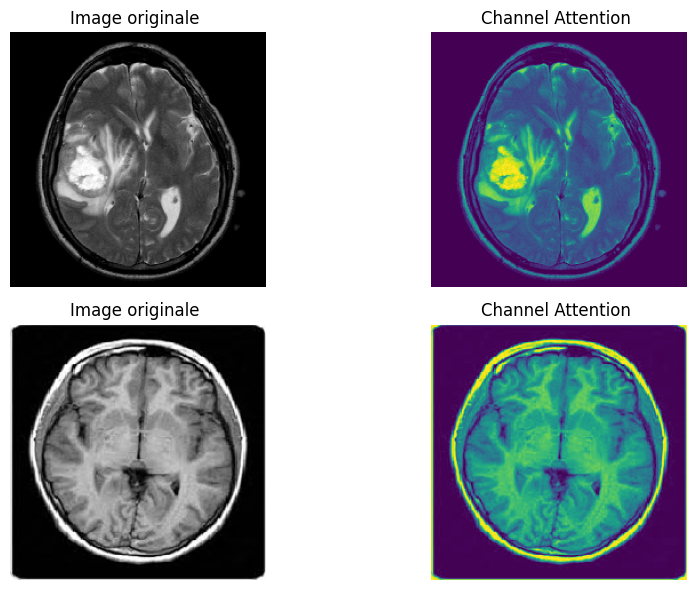

In [44]:
# Affichage
plt.figure(figsize=(10, 6))
for i, img_path in enumerate(img_paths):
    input_batch, original_img = load_and_preprocess_image(img_path)

    # Passage par le module de Channel Attention
    attention_output = channel_attention(tf.convert_to_tensor(input_batch)).numpy()

    # Calcul d'une "carte d'attention" approximative (moyenne des canaux)
    attention_map = np.mean(attention_output[0], axis=-1)

    # Image originale
    plt.subplot(2, 2, i*2+1)
    plt.imshow(original_img)
    plt.title(f"Image originale ")
    plt.axis('off')

    # Carte de channel attention
    plt.subplot(2, 2, i*2+2)
    plt.imshow(attention_map, cmap='viridis')
    plt.title(f"Channel Attention ")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
def build_attention_model():
    input_tensor = Input(shape=(224, 224, 3))
    
    # CNN de base
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((2,2))(x)

    # Channel Attention
    x = channel_attention(x)
    
    # Suite du CNN
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # pour binaire
    
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [27]:
model_channel = build_attention_model()
model_channel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
model_channel.fit(train_generator, validation_data=valid_generator, epochs=20)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5550 - loss: 1.5472 - val_accuracy: 0.6184 - val_loss: 0.6615
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7111 - loss: 0.5980 - val_accuracy: 0.6579 - val_loss: 0.6533
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6400 - loss: 0.6341 - val_accuracy: 0.6711 - val_loss: 0.6693
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7257 - loss: 0.5731 - val_accuracy: 0.6974 - val_loss: 0.5963
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7382 - loss: 0.5591 - val_accuracy: 0.7105 - val_loss: 0.5642
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7532 - loss: 0.5288 - val_accuracy: 0.7105 - val_loss: 0.5550
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7397 - loss: 0.5635 - val_accuracy: 0.7763 - val_loss: 0.5721
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7785 - loss: 0.4649 - val_accuracy: 0.7105 - val_loss:

In [33]:
test_loss, test_acc = model_channel.evaluate(test_generator, verbose=0)
print(f"Accuracy sur le jeu de test avec channel_attention  : {test_acc:.4f}")

Accuracy sur le jeu de test avec channel_attention  : 0.8289


# **7.2. Spatial Attention Module**

In [10]:
def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1,
                          kernel_size=7,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    output = Multiply()([input_feature, cbam_feature])
    return output, cbam_feature 

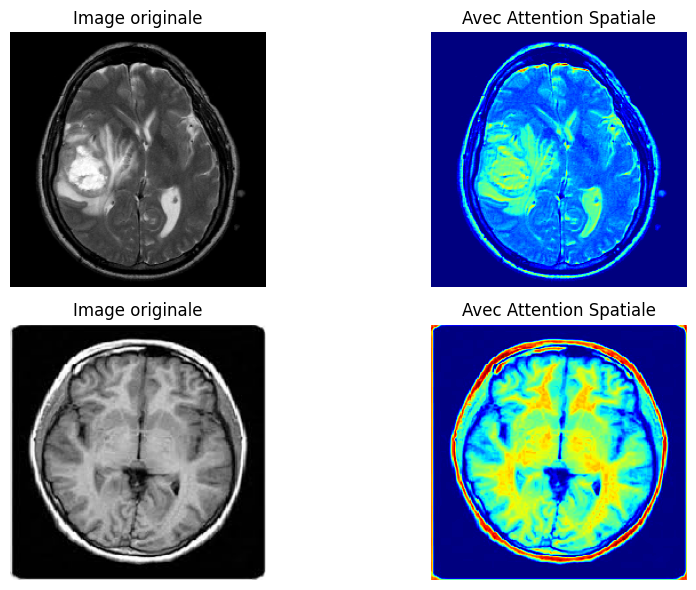

In [17]:
# Afficher les résultats
plt.figure(figsize=(10, 6))

for i, img_path in enumerate(img_paths):
    # Charger l'image
    input_batch, original_img = load_and_preprocess_image(img_path)
    input_tensor = tf.convert_to_tensor(input_batch)

    # Appliquer spatial attention
    attended_output, attention_map = spatial_attention(input_tensor)

    # Affichage image originale
    plt.subplot(2, 2, i * 2 + 1)
    plt.imshow(original_img)
    plt.title("Image originale")
    plt.axis("off")

    # Affichage image après attention spatiale (moyenne des canaux)
    attention_output_np = attended_output.numpy()[0]
    attention_display = np.mean(attention_output_np, axis=-1)
    plt.subplot(2, 2, i * 2 + 2)
    plt.imshow(attention_display, cmap='jet')
    plt.title("Avec Attention Spatiale")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Input layer
input_layer = Input(shape=(224, 224, 3))

# CNN classique
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D((2,2))(x)

# Appliquer attention spatiale
x, attention_map = spatial_attention(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Créer le modèle
model_spatial = Model(inputs=input_layer, outputs=output_layer)

In [12]:
# Compiler le modèle
model_spatial.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
 model_spatial.fit(train_generator, validation_data=valid_generator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5701 - loss: 1.6307 - val_accuracy: 0.6447 - val_loss: 0.6261
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6319 - loss: 0.6433 - val_accuracy: 0.7105 - val_loss: 0.5660
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7376 - loss: 0.5801 - val_accuracy: 0.6579 - val_loss: 0.5847
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6529 - loss: 0.6275 - val_accuracy: 0.7105 - val_loss: 0.5719
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7321 - loss: 0.5565 - val_accuracy: 0.6974 - val_loss: 0.5453
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7800 - loss: 0.5428 - val_accuracy: 0.6974 - val_loss: 0.5329
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7260 - loss: 0.5348 - val_accuracy: 0.6842 - val_loss: 0.5296
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7815 - loss: 0.4951 - val_accuracy: 0.7237 - val_loss: 0.5581
Epo

In [14]:
test_loss, test_acc = model_spatial.evaluate(test_generator, verbose=0)
print(f"Accuracy sur le jeu de test : {test_acc:.4f}")

Accuracy sur le jeu de test : 0.8553


In [ ]:
model = keras.models.load_model("model_spatial.h5", compile=False)
model.save("model_spatial.keras")

# **7.3. Module CBAM complet**

In [47]:
def cbam_block(input_feature):
    channel_refined = channel_attention(input_feature)
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    attention_map = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined = Multiply()([channel_refined, attention_map])
    return refined, attention_map  # <-- on retourne aussi la carte

In [48]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(2,2)(x)
x, attention_map = cbam_block(x)

# suite du modèle, sans attention :
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Modèle qui retourne à la fois la prédiction et la carte d’attention
attention_model = Model(inputs=input_layer, outputs=[output, attention_map])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


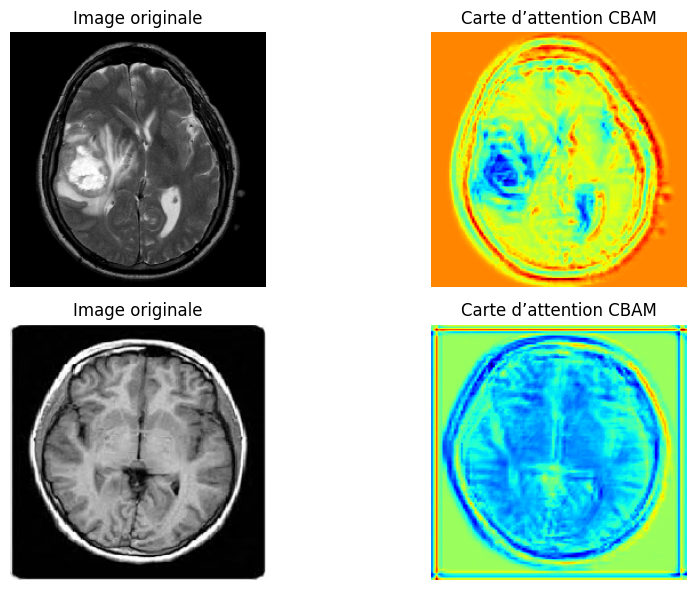

In [49]:
plt.figure(figsize=(10, 6))

for i, img_path in enumerate(img_paths):
    input_batch, original_img = load_and_preprocess_image(img_path)
    prediction, att_map = attention_model.predict(input_batch)  # (1,), (1, H, W, 1)

    att_map = att_map[0, :, :, 0]  # on squeeze
    att_map = (att_map - np.min(att_map)) / (np.max(att_map) - np.min(att_map))  # normalisation

    # Image originale
    plt.subplot(2, 2, i * 2 + 1)
    plt.imshow(original_img)
    plt.title("Image originale")
    plt.axis("off")

    # Carte d’attention
    plt.subplot(2, 2, i * 2 + 2)
    plt.imshow(att_map, cmap='jet')
    plt.title("Carte d’attention CBAM")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [50]:
model_cbam = Model(inputs=input_layer, outputs=output)
model_cbam.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [51]:
model_cbam.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 112, 112, 32)   │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_5[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_2    │ (None, 32)             │              0 │ max_pooling2d_5[0][0]  │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 1, 32)       │              0 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1, 4)        │            132 │ reshape_4[0][0],       │
│                           │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1, 32)       │            160 │ dense_9[0][0],         │
│                           │                        │                │ dense_9[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 1, 32)       │              0 │ dense_10[0][0],        │
│                           │                        │                │ dense_10[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1, 1, 32)       │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 112, 112, 32)   │              0 │ max_pooling2d_5[0][0], │
│                           │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 112, 112, 1)    │              0 │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 112, 112, 1)    │              0 │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 112, 112, 2)    │              0 │ lambda_4[0][0],        │
│ (Concatenate)             │                        │                │ lambda_5[0][0]         │
├──────────────────────

 Total params: 25,710,152 (98.08 MB)

 Trainable params: 25,710,152 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history_cbam = model_cbam.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6301 - loss: 0.8851 - val_accuracy: 0.6842 - val_loss: 0.6079
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6888 - loss: 0.6322 - val_accuracy: 0.6447 - val_loss: 0.5901
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7207 - loss: 0.6055 - val_accuracy: 0.6711 - val_loss: 0.5901
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7379 - loss: 0.5615 - val_accuracy: 0.7105 - val_loss: 0.5923
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7395 - loss: 0.5382 - val_accuracy: 0.7105 - val_loss: 0.6031
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7492 - loss: 0.4976 - val_accuracy: 0.5789 - val_loss: 0.6923
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6634 - loss: 0.6030 - val_accuracy: 0.6974 - val_loss: 0.6101
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6924 - loss: 0.6130 - val_accuracy: 0.7237 - val_loss:

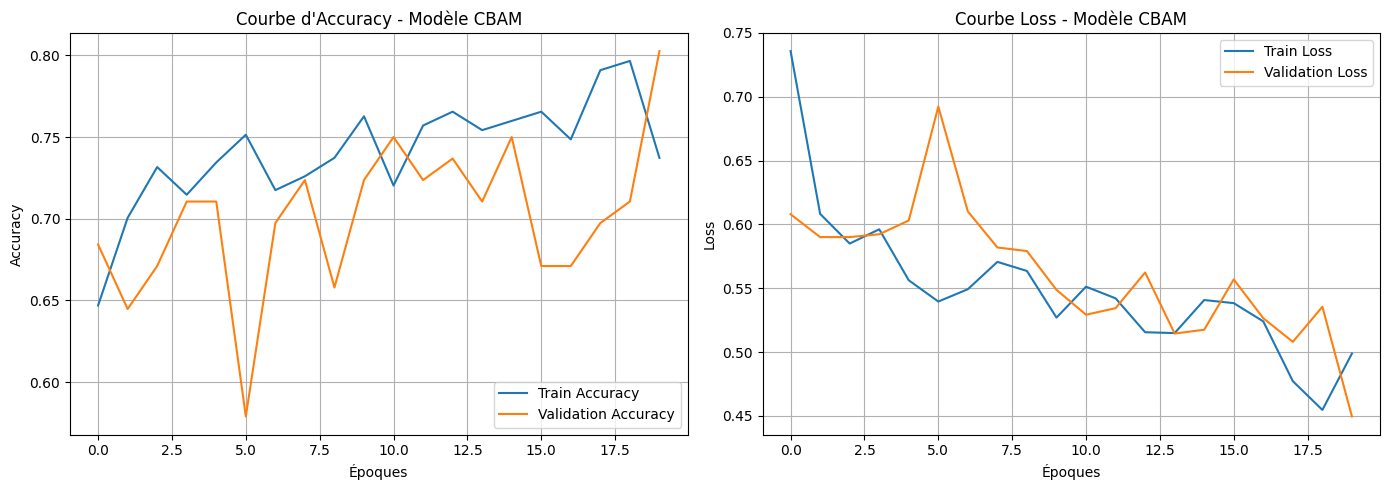

In [53]:
# Récupérer l'historique
acc = history_cbam.history['accuracy']
val_acc = history_cbam.history['val_accuracy']
loss = history_cbam.history['loss']
val_loss = history_cbam.history['val_loss']
epochs_range = range(len(acc))

# Tracer
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Courbe d\'Accuracy - Modèle CBAM')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Courbe Loss - Modèle CBAM')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.grid()

plt.tight_layout()
plt.show()

In [54]:
test_loss, test_acc = model_cbam.evaluate(test_generator, verbose=0)
print(f"Accuracy sur le jeu de test : {test_acc:.4f}")
val_acc = history_cbam.history['val_accuracy'][-1]
print(f"Accuracy sur le jeu de validation : {val_acc:.4f}")

Accuracy sur le jeu de test : 0.7895
Accuracy sur le jeu de validation : 0.8026
